In [1]:
%pylab nbagg

import os
import functools

import h5py
import pyFAI

from collections import namedtuple
from typing import List, Tuple

from fabio.edfimage import edfimage
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

import ipywidgets as widgets


# local import
from soleil import Angle, Calibrant, CalibrationMarsTxTz, CalibrationFunctions, CalibrationMarsTxTzFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathContainsDefault, DatasetPathWithAttribute, get_dataset,\
    calibration_mars_tx_tz, integrate_mars_tx_tz, save_as_edf_mars_tx_tz

Populating the interactive namespace from numpy and matplotlib


Il y a six types de fichiers à traiter.

nb images | tz      | poni
----------|---------|
5         |  -1     | x
5         |  0      | scan3.poni
5         |  x(-1)  | x
5         |  x(0)   | scan3.poni
1         |  -1     | x
1         |  0      | scan3.poni

In [2]:
ROOT = "/home/experiences/instrumentation/picca/jupyter/mars/20160800/"
PUBLISHED = os.path.join(ROOT, "published-data")

In [3]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = 0.258705917299
poni1_scale = 0.001  # TODO
poni1_offset = 0.12  # TODO
poni2_scale = 0.001
poni2_offset = -0.9488181818181818
rot1 = 0.00388272369359
rot2 = -0.00942588451226
rot3 = 7.19961198098e-07


functions = (
    CalibrationFunctions("dist",
                         "tz * poni1_scale + poni1_offset",
                         "tx * poni2_scale + poni2_offset",
                         "rot1",
                         "rot2",
                         "rot3"),    
    [Parameter[Length]("dist", distance, (distance-0.05, distance+0.05)),
     Parameter[float]("poni1_scale", poni1_scale, (poni1_scale, poni1_scale)),
     Parameter[Length]("poni1_offset", poni1_offset, (poni1_offset-1, poni1_offset+1)),
     Parameter[float]("poni2_scale", poni2_scale, (poni2_scale, poni2_scale)),
     Parameter[Length]("poni2_offset", poni2_offset, (poni2_offset-1, poni2_offset+1)),
     Parameter[Angle]("rot1", rot1, (rot1, rot1)),
     Parameter[float]("rot2", rot2, (rot2-0.1, rot2+0.1)),
     Parameter[Angle]("rot3", rot3, (rot3, rot3))]
)

# conserve the image available for calibration, remove others
def to_use(frame: CalibrationMarsTxTzFrame) -> bool:
   
    return True if frame.idx in range(0,30) else False

def mkCalibrationMarsTxTz(filename: str, tz: float, idxs: List[int]):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd", "calibration"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               #tz, # tz
                               DatasetPathContainsDefault("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value", tz),  # tz
                               idxs,
                               to_use,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions
                              ) 
    
params = [mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_3_01.nxs"), 0.0, [2, 5, 8]),
          mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_4_01.nxs"), -1.0, [2, 5])]

In [4]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
emacs = my_cmd_button("emacs soleil.py", "Edit the soleil.py file")

In [6]:
for param in params:
    my_cmd_button("silx view --use-opengl-plot " + param.filename,
                  'Silx View ' + os.path.basename(param.filename))

In [7]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

for param in params:
    cmds = save_as_edf_mars_tx_tz(param)
    for cmd, idx in zip(cmds, param.idxs):
        my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(param.filename) + " " + str(idx))

In [ ]:
# execute the calibration

calibration_mars_tx_tz(params, json)

In [ ]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)

In [ ]:
# il faudrait fair eune calibration avec l'ensemble des fichiers des scan3 et 4.
# scan3 10 images tx variant et tz=0.
# scan4 10 imagfes tx variant et tz = -1.

# TODO add the second scan for the calibration.
# TODO mask

In [ ]:
# extraction des scans avec 6 positions en tx, quelque soit tz.
# CEs ont les seuls que nous pouvons traiter pour l'instant car
# la calibration n'a été faite que pour un tx de 6.
# LONG
import glob

files = glob.glob(os.path.join(ROOT, "*.nxs"))

def is_ok(filename: str) -> bool:
    with h5py.File(filename, mode='r') as f:
        for imgs, tx, tz in zip(get_images(f), get_tx(f), get_tz(f)):
            return True if tx.shape[0] == 6 else False

#good = [f for f in files if is_ok(f)]
#print(good)

<IPython.core.display.Javascript object>


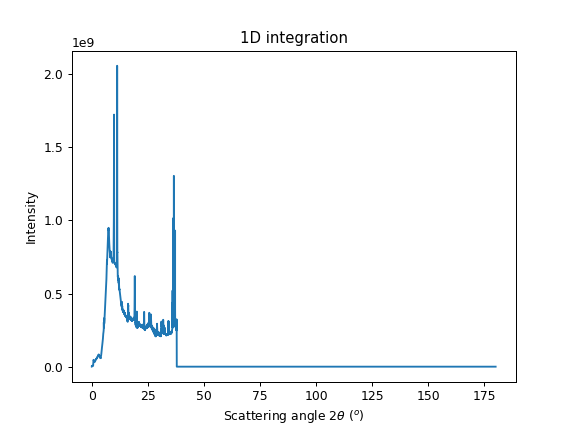

<IPython.core.display.Javascript object>


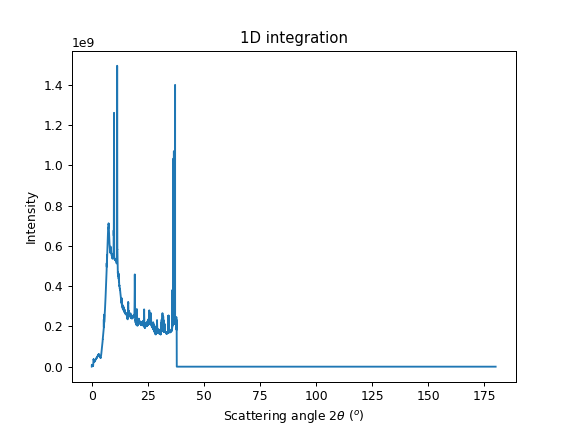

<IPython.core.display.Javascript object>


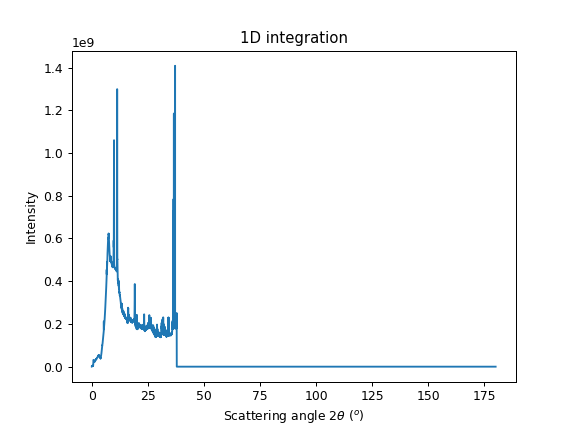

<IPython.core.display.Javascript object>


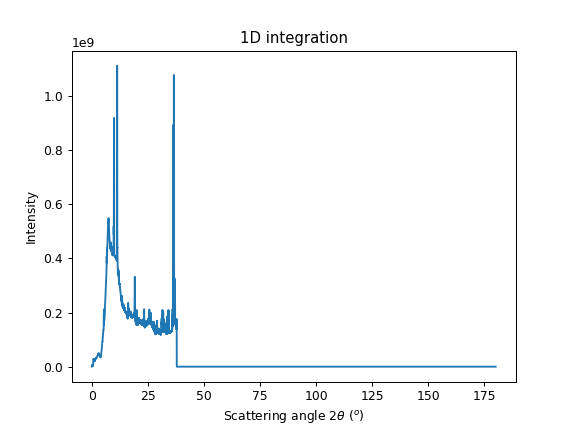

<IPython.core.display.Javascript object>


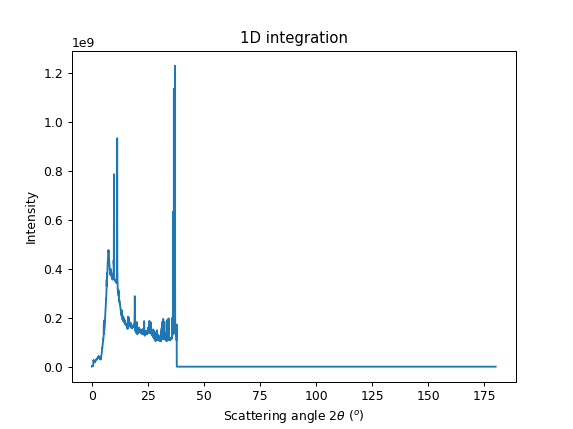

<IPython.core.display.Javascript object>


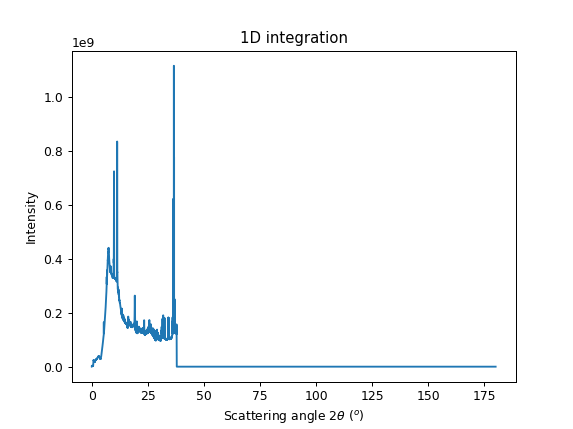

<IPython.core.display.Javascript object>


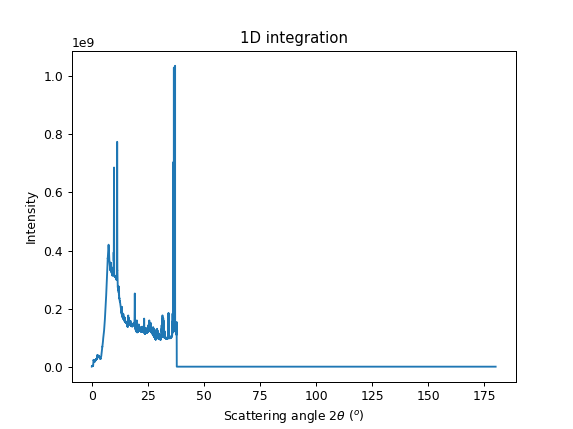

<IPython.core.display.Javascript object>


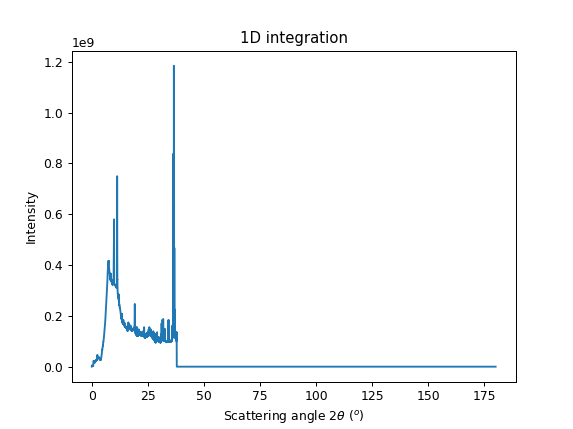

In [12]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               DatasetPathContains("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions
                              ) 

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx))),
            mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx+1)))]


samples = [mkSampleMarsTxTzP(idx) for idx in range(77, 92, 2)]
                             
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

for sample in samples:
    integrate_mars_tx_tz(json, sample, f, n=50000, save=True)